## FELINE RETICULOCYTE % CALCULATOR - PRE - PROCESSING

In [2]:
import numpy as np
import pandas as pd
import os
import xml.etree.ElementTree as ET
import cv2
from matplotlib import pyplot as plt

#### READ DATASET AND CREATE BOUNDING BOX DATASET

In [113]:
image_directory = 'D:\\MS_TOPICSELECTION\\TOPIC_SUBMISSION\\data_300x300\\data_300x300\\images'
_, _, image_files = next(os.walk(image_directory))

In [114]:
len(image_files)

1086

In [115]:
label_directory = 'D:\\MS_TOPICSELECTION\\TOPIC_SUBMISSION\\data_300x300\\data_300x300\\labels'
_, _, label_files = next(os.walk(label_directory))

In [116]:
len(label_files)

1086

In [117]:
image_files[:5]

['000045.jpg', '000058.jpg', '000061.jpg', '000078.jpg', '000087.jpg']

In [118]:
label_files[:5]

['000045.xml', '000058.xml', '000061.xml', '000078.xml', '000087.xml']

#### PARSE LABEL FILES AND POULATE THE DATAFRAME

In [3]:
def parse_label(label_files):
    label_data = []

    for label in label_files:
        xml_tree = ET.parse(label_directory+'\\'+label)
        root = xml_tree.getroot()
        image_file = root.find('filename').text
        size_elem =root.find('size')
        height = float(size_elem.find('height').text)
        width =  float(size_elem.find('width').text)

        # For every bounding box get the details (x1, y1, x2, y2)
        for bbox in root.findall('object'):
            # Bounding box coordinates
            bounding_box = bbox.find('bndbox')
            xmin = float(bounding_box.find('xmin').text)
            xmax = float(bounding_box.find('xmax').text)
            ymin = float(bounding_box.find('ymin').text)
            ymax = float(bounding_box.find('ymax').text)
            class_label =  bbox.find('name').text
            label_data.append([image_file, width, height, class_label, xmin, ymin, xmax, ymax])
    bbox_df = pd.DataFrame(data=label_data, columns=['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax'])
    return bbox_df

In [120]:
bbox_df = parse_label(label_files)

In [122]:
grouped_df = bbox_df.groupby('class').count()
grouped_df

,filename,width,height,xmin,ymin,xmax,ymax
class,,,,,,,
aggregate reticulocyte,1001,1001,1001,1001,1001,1001,1001
erythrocyte,1979,1979,1979,1979,1979,1979,1979
punctate reticulocyte,1010,1010,1010,1010,1010,1010,1010


<AxesSubplot:xlabel='class'>

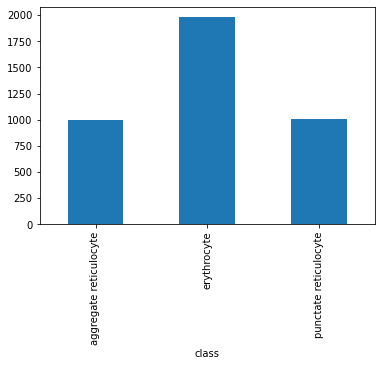

In [123]:
grouped_df['filename'].plot.bar()

#### SCRIPT TO PERFORM CLAHE

In [12]:
def perform_histogram_equalization(image_file):
    input_image = cv2.imread(image_file)
    input_image_rgb = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    r_image, g_image, b_image = cv2.split(input_image_rgb)
    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(6,6))
    r_image_eq = clahe.apply(r_image)
    g_image_eq = clahe.apply(g_image)
    b_image_eq = clahe.apply(b_image)
    equalized_image = cv2.merge((b_image_eq, g_image_eq, r_image_eq))
    return input_image, equalized_image

In [13]:
def display_image(input_image, equalized_image):
    fig = plt.figure(figsize=(10, 20))

    ax1 = fig.add_subplot(2, 2, 1)
    ax1.axis("off")
    ax1.title.set_text('Original')
    ax2 = fig.add_subplot(2, 2, 2)
    ax2.axis("off")
    ax2.title.set_text("CLAHE")
    b_image, g_image, r_image = cv2.split(input_image)
    merged_input = cv2.merge((r_image, g_image, b_image)) 
    b_image, g_image, r_image = cv2.split(equalized_image)
    merged_equalized_image = cv2.merge((r_image, g_image, b_image)) 
    ax1.imshow(merged_input)
    ax2.imshow(merged_equalized_image)

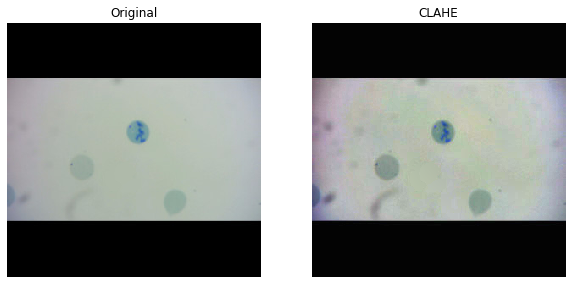

In [14]:
input_image, equalized_image = perform_histogram_equalization('D:\\MS_TOPICSELECTION\\TOPIC_SUBMISSION\\data_300x300\\data_300x300\\images\\000045.jpg')
display_image(input_image, equalized_image)

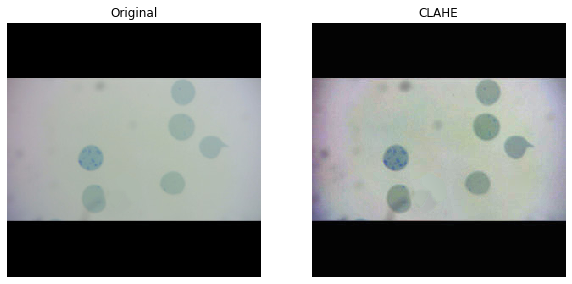

In [15]:
input_image, equalized_image = perform_histogram_equalization('D:\\MS_TOPICSELECTION\\TOPIC_SUBMISSION\\data_300x300\\data_300x300\\images\\000175.jpg')
display_image(input_image, equalized_image)

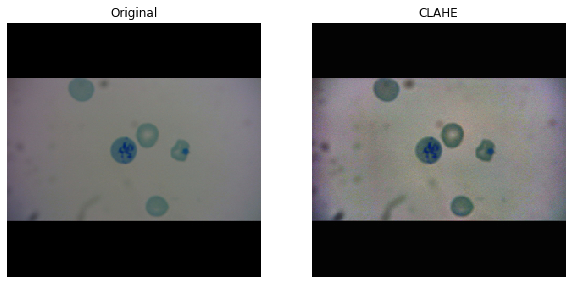

In [16]:
input_image, equalized_image = perform_histogram_equalization('D:\\MS_TOPICSELECTION\\TOPIC_SUBMISSION\\data_300x300\\data_300x300\\images\\001694.jpg')
display_image(input_image, equalized_image)

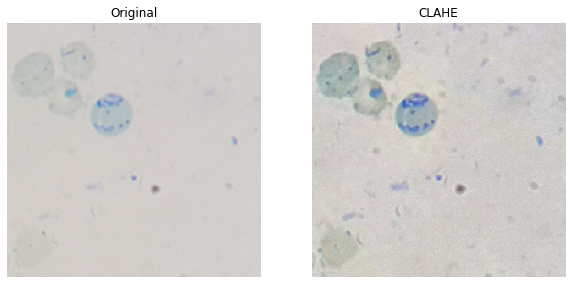

In [17]:
input_image, equalized_image = perform_histogram_equalization('D:\\MS_TOPICSELECTION\\TOPIC_SUBMISSION\\data_300x300\\data_300x300\\images\\001206.jpg')
display_image(input_image, equalized_image)

In [53]:
pre_proc_directory = 'D:\\MS_TOPICSELECTION\\TOPIC_SUBMISSION\\data_300x300\\data_300x300\\images_preproc\\'
for image in image_files:
    org, preproc = perform_histogram_equalization(image_directory+'\\'+image)
    cv2.imwrite(pre_proc_directory+'\\'+image, preproc)

### TRAIN TEST AND VALIDATION SPLITS

In [20]:
# Images from 000542.jpg - 001232.jpg are taken using mobile phone camera. So we will split the dataset first to two
# Pics taken using microscope vs those taken using mobile phone

start_index = image_files.index('000542.jpg')
end_index = image_files.index('001232.jpg')

mobile_images = image_files[start_index:(end_index+1)]
microscope_images = [img for img in image_files if img not in mobile_images ]

In [21]:
len(mobile_images)

516

In [22]:
len(microscope_images)

570

In [24]:
mobile_images[-5:]

['001227.jpg', '001228.jpg', '001229.jpg', '001230.jpg', '001232.jpg']

In [25]:
mobile_images[:5]

['000542.jpg', '000543.jpg', '000551.jpg', '000555.jpg', '000557.jpg']

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
mobile_images_train, mobile_images_test = train_test_split(mobile_images, test_size=0.2, random_state=42)

In [29]:
print("Length of train data: ", len(mobile_images_train))
print("Length of test data: ", len(mobile_images_test))

Length of train data:  412
Length of test data:  104


In [30]:
microscope_images_train, microscope_images_test = train_test_split(microscope_images, test_size=0.2, random_state=42)
print("Length of train data: ", len(microscope_images_train))
print("Length of test data: ", len(microscope_images_test))

Length of train data:  456
Length of test data:  114


In [31]:
import random
training_data_set_final = mobile_images_train + microscope_images_train
random.shuffle(training_data_set_final)
print("length of final train data: ", len(training_data_set_final))

length of final train data:  868


In [32]:
test_val_data = mobile_images_test + microscope_images_test
len(test_val_data)

218

In [33]:
test_val_data[:10]

['000909.jpg',
 '001207.jpg',
 '001136.jpg',
 '000738.jpg',
 '001210.jpg',
 '000714.jpg',
 '000796.jpg',
 '001227.jpg',
 '000933.jpg',
 '000844.jpg']

In [34]:
random.shuffle(test_val_data)

In [35]:
test_val_data[:10]

['001544.jpg',
 '000801.jpg',
 '001291.jpg',
 '001248.jpg',
 '001238.jpg',
 '000796.jpg',
 '001684.jpg',
 '000646.jpg',
 '000817.jpg',
 '000987.jpg']

In [36]:
test_dataset_final, val_dataset_final = train_test_split(test_val_data, test_size=0.5, random_state=42)
print("Length of test_dataset_final: ", len(test_dataset_final))
print("Length of val_dataset_final: ", len(val_dataset_final))

Length of test_dataset_final:  109
Length of val_dataset_final:  109


In [38]:
bbox_df_train = bbox_df[bbox_df.filename.isin(training_data_set_final)]

In [39]:
bbox_df_train.filename.nunique()

868

In [40]:
grouped_train_df = bbox_df_train.groupby('class').count()
grouped_train_df

,filename,width,height,xmin,ymin,xmax,ymax
class,,,,,,,
aggregate reticulocyte,799,799,799,799,799,799,799
erythrocyte,1581,1581,1581,1581,1581,1581,1581
punctate reticulocyte,832,832,832,832,832,832,832


In [41]:
bbox_df_val = bbox_df[bbox_df.filename.isin(val_dataset_final)]
bbox_df_val.filename.nunique()

109

In [136]:
grouped_val_df = bbox_df_val.groupby('class').count()
grouped_val_df['filename']

class
aggregate reticulocyte    100
erythrocyte               208
punctate reticulocyte      88
Name: filename, dtype: int64

In [43]:
bbox_df_test = bbox_df[bbox_df.filename.isin(test_dataset_final)]
bbox_df_test.filename.nunique()

109

In [44]:
grouped_test_df = bbox_df_test.groupby('class').count()
grouped_test_df['filename']

class
aggregate reticulocyte    102
erythrocyte               190
punctate reticulocyte      90
Name: filename, dtype: int64

In [52]:
from shutil import copyfile
destination_train = 'D:\\MS_TOPICSELECTION\\TOPIC_SUBMISSION\\data_300x300\\data_300x300\\Train\\'
destination_val = 'D:\\MS_TOPICSELECTION\\TOPIC_SUBMISSION\\data_300x300\\data_300x300\\Val\\'
destination_test = 'D:\\MS_TOPICSELECTION\\TOPIC_SUBMISSION\\data_300x300\\data_300x300\\Test\\'
src_image = 'D:\\MS_TOPICSELECTION\\TOPIC_SUBMISSION\\data_300x300\\data_300x300\\images_preproc\\'
src_label = 'D:\\MS_TOPICSELECTION\\TOPIC_SUBMISSION\\data_300x300\\data_300x300\\labels\\'
for file in image_files:
    if file in training_data_set_final:
        copyfile(src_image+file, destination_train+file)
        labelfile = file.replace(".jpg", ".xml")
        copyfile(src_label+labelfile, destination_train+labelfile)
    elif file in val_dataset_final:
        copyfile(src_image+file, destination_val+file)
        labelfile = file.replace(".jpg", ".xml")
        copyfile(src_label+labelfile, destination_val+labelfile)
    elif file in test_dataset_final:
        copyfile(src_image+file, destination_test+file)
        labelfile = file.replace(".jpg", ".xml")
        copyfile(src_label+labelfile, destination_test+labelfile)

## YOLO DATASET CREATION 

In [20]:
lblmap = {'erythrocyte': 0, 'punctate reticulocyte': 1, 'aggregate reticulocyte': 2}

In [21]:
def parse_label(label_file, input_path, output_path):
    xml_tree = ET.parse(input_path+'\\'+label_file)
    root = xml_tree.getroot()
    image_file = root.find('filename').text
    size_elem =root.find('size')
    height = float(size_elem.find('height').text)
    width =  float(size_elem.find('width').text)
    with open(output_path+'\\'+label_file.replace('.xml','.txt'), 'w') as yolo_label:
        # For every bounding box get the details (x1, y1, x2, y2)
        for bbox in root.findall('object'):
            # Bounding box coordinates
            bounding_box = bbox.find('bndbox')
            xmin = float(bounding_box.find('xmin').text)
            xmax = float(bounding_box.find('xmax').text)
            ymin = float(bounding_box.find('ymin').text)
            ymax = float(bounding_box.find('ymax').text)
            class_label =  bbox.find('name').text
            obj_label = lblmap[class_label]

            x_center = (xmin+xmax)/2
            x_center = x_center/width
            y_center = (ymin+ymax)/2
            y_center = y_center/height
            obj_width = (xmax - xmin)/width
            obj_height = (ymax - ymin)/height
            yolo_label.write(str(obj_label)+' '+str(x_center)+' '+str(y_center)+' '+str(obj_width)+' '+str(obj_height)+'\n')

In [22]:
from shutil import copyfile
def create_yolo_dataset(input_path, output_path):
    _, _, all_files = next(os.walk(input_path))
    img_file_names = [imgfile for imgfile in all_files if '.jpg' in imgfile]
    lbl_file_names = [lblfile for lblfile in all_files if '.xml' in lblfile]
    for img, lbl in zip(img_file_names, lbl_file_names):
        copyfile(input_path+'\\'+img, output_path+'\\image\\'+img)
        parse_label(lbl, input_path, output_path+'\\label')

In [23]:
inpath = 'D:\\MS_TOPICSELECTION\\TOPIC_SUBMISSION\\data_300x300\\data_300x300\\Test'
outpath = 'D:\\MS_TOPICSELECTION\\TOPIC_SUBMISSION\\YOLO_DATA\\test'
create_yolo_dataset(inpath, outpath)

In [24]:
inpath = 'D:\\MS_TOPICSELECTION\\TOPIC_SUBMISSION\\data_300x300\\data_300x300\\Val'
outpath = 'D:\\MS_TOPICSELECTION\\TOPIC_SUBMISSION\\YOLO_DATA\\val'
create_yolo_dataset(inpath, outpath)

In [25]:
inpath = 'D:\\MS_TOPICSELECTION\\TOPIC_SUBMISSION\\data_300x300\\data_300x300\\Train'
outpath = 'D:\\MS_TOPICSELECTION\\TOPIC_SUBMISSION\\YOLO_DATA\\train'
create_yolo_dataset(inpath, outpath)

### AUGMENTATION AND CREATION OF NEW DATA POINTS

In [468]:
import random

import cv2
from matplotlib import pyplot as plt
import albumentations as A

In [5]:
label_directory = 'D:\\MS_TOPICSELECTION\\TOPIC_SUBMISSION\\data_300x300\\data_300x300\\FinalTrainLabel\\'
_, _, train_label_files = next(os.walk(label_directory))

In [6]:
img_dir = 'D:\\MS_TOPICSELECTION\\TOPIC_SUBMISSION\\data_300x300\\data_300x300\\FinalTrainImages\\'
_, _, train_imgs_files = next(os.walk(img_dir))

In [7]:
len(train_label_files)

977

In [9]:
train_xml_without_tag = [x.strip('.xml') for x in train_label_files]

In [12]:
train_xml_without_tag[:5]

['000045', '000058', '000078', '000087', '000093']

In [14]:
train_img_without_tag = [x.strip('.jpg') for x in train_imgs_files]

In [15]:
train_img_without_tag[:5]

['000045', '000058', '000078', '000087', '000093']

In [16]:
set(train_xml_without_tag) - set(train_img_without_tag)

set()

In [17]:
train_bbox_df = parse_label(train_label_files)

In [18]:
len(train_bbox_df)

3594

In [19]:
train_bbox_df.columns

Index(['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax'], dtype='object')

In [20]:
train_bbox_df.filename.nunique()

977

In [21]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, x_max, y_max, class_name = int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3]), bbox[4]
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes):
    img = image.copy()
    for bbox in bboxes:
        img = visualize_bbox(img, bbox)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

In [22]:
image_file_names = list(train_bbox_df.filename.unique())

In [23]:
bbox_image1 = train_bbox_df[train_bbox_df.filename == image_file_names[0]]

In [24]:
bbox_image1

,filename,width,height,class,xmin,ymin,xmax,ymax
0,000045.jpg,300.0,300.0,aggregate reticulocyte,140.0,115.0,169.0,143.0
1,000045.jpg,300.0,300.0,punctate reticulocyte,72.0,155.0,103.0,187.0
2,000045.jpg,300.0,300.0,erythrocyte,184.0,195.0,213.0,228.0


In [25]:
bb_final_selection = bbox_image1[['xmin', 'ymin', 'xmax', 'ymax', 'class']]

In [26]:
bb_final_selection

,xmin,ymin,xmax,ymax,class
0,140.0,115.0,169.0,143.0,aggregate reticulocyte
1,72.0,155.0,103.0,187.0,punctate reticulocyte
2,184.0,195.0,213.0,228.0,erythrocyte


In [27]:
list_bbox = bb_final_selection.values.tolist()

In [28]:
list_bbox

[[140.0, 115.0, 169.0, 143.0, 'aggregate reticulocyte'],
 [72.0, 155.0, 103.0, 187.0, 'punctate reticulocyte'],
 [184.0, 195.0, 213.0, 228.0, 'erythrocyte']]

In [29]:
transform = A.Compose([
        A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
        ], p=0.5),
        A.OneOf([
            A.IAAAdditiveGaussianNoise(),
            A.GaussNoise(),
        ], p=0.2),
        A.RandomSizedBBoxSafeCrop(width=300, 
                                  height=300, 
                                  erosion_rate=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, 
                           scale_limit=0.1, 
                           rotate_limit=10, p=0.4),
        A.OneOf([
            A.IAASharpen(),
            A.IAAEmboss(),
            A.RandomBrightnessContrast(),            
        ], p=0.3),

    ], bbox_params=A.BboxParams(format='pascal_voc'))


C:\Users\sreens\Anaconda3\envs\DL_ENV\lib\site-packages\albumentations\imgaug\transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
C:\Users\sreens\Anaconda3\envs\DL_ENV\lib\site-packages\albumentations\imgaug\transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
C:\Users\sreens\Anaconda3\envs\DL_ENV\lib\site-packages\albumentations\imgaug\transforms.py:165: FutureWarning: This augmentation is deprecated. Please use Emboss instead
  warnings.warn("This augmentation is deprecated. Please use Emboss instead", FutureWarning)


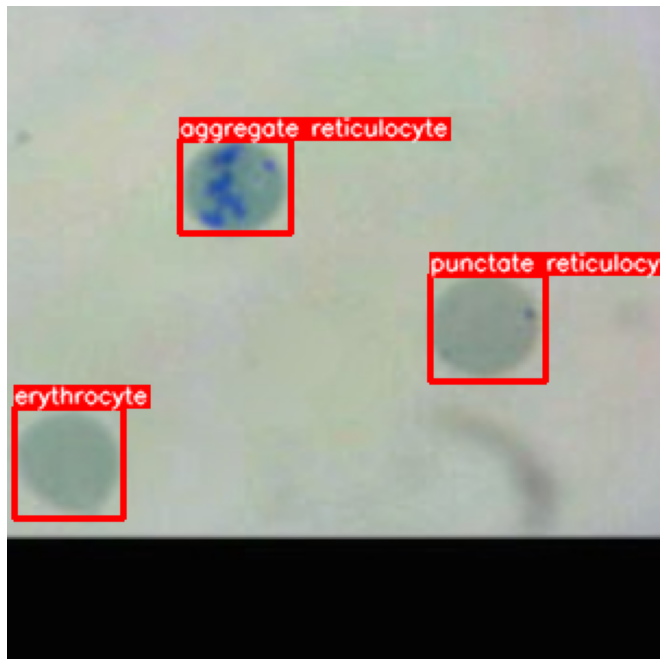

In [30]:
image = "D:\\MS_TOPICSELECTION\\TOPIC_SUBMISSION\\data_300x300\\data_300x300\\FinalTrainImages\\000045.jpg"
image = cv2.imread(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
transform_data = transform(image=image, bboxes=list_bbox)
visualize(transform_data['image'], transform_data['bboxes'])

In [31]:
transform_data['bboxes']

[(79.76878612716763,
  61.53846153846156,
  130.0578034682081,
  104.61538461538461,
  'aggregate reticulocyte'),
 (194.2196531791908,
  123.07692307692312,
  247.97687861271675,
  172.3076923076923,
  'punctate reticulocyte'),
 (3.468208092485574,
  184.6153846153846,
  53.75722543352603,
  235.3846153846154,
  'erythrocyte')]

In [32]:
transform_data['image'].shape

(300, 300, 3)

In [33]:
augmented_bounding_box = []
def create_augmeted_images(label_directory = 'D:\\MS_TOPICSELECTION\\TOPIC_SUBMISSION\\data_300x300\\data_300x300\\FinalTrainLabel\\',
                           image_directory = 'D:\\MS_TOPICSELECTION\\TOPIC_SUBMISSION\\data_300x300\\data_300x300\\FinalTrainImages\\'):
    _, _, train_label_files = next(os.walk(label_directory))
    train_bbox_df = parse_label(train_label_files)
    image_file_names = list(train_bbox_df.filename.unique())
    for image_name in image_file_names:
        print(image_name)
        org_img = image_directory+image_name
        for i in range(4):
            new_img = image_name.strip('.jpg')+'_'+str(i)+'.jpg'
            bbox_image = train_bbox_df[train_bbox_df.filename == image_name]
            bb_final_selection = bbox_image[['xmin', 'ymin', 'xmax', 'ymax', 'class']]
            list_bbox = bb_final_selection.values.tolist()
            image = cv2.imread(org_img)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            transform_data = transform(image=image, bboxes=list_bbox)
            cv2.imwrite(image_directory+new_img, transform_data['image'])
            for bbox in transform_data ['bboxes']:
                box = []
                x_min, y_min, x_max, y_max, class_name = int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3]), bbox[4]
                box.append(new_img)
                box.append(transform_data['image'].shape[0])
                box.append(transform_data['image'].shape[1])
                box.append(class_name)
                box.append(x_min)
                box.append(y_min)
                box.append(x_max)
                box.append(y_max)
                augmented_bounding_box.append(box)         

In [34]:
len(train_bbox_df)

3594

In [35]:
train_bbox_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,000045.jpg,300.0,300.0,aggregate reticulocyte,140.0,115.0,169.0,143.0
1,000045.jpg,300.0,300.0,punctate reticulocyte,72.0,155.0,103.0,187.0
2,000045.jpg,300.0,300.0,erythrocyte,184.0,195.0,213.0,228.0
3,000058.jpg,300.0,300.0,erythrocyte,174.0,65.0,203.0,94.0
4,000058.jpg,300.0,300.0,aggregate reticulocyte,120.0,113.0,151.0,143.0


In [36]:
create_augmeted_images()

000045.jpg
000058.jpg
000078.jpg
000087.jpg
000093.jpg
000124.jpg
000135.jpg
000140.jpg
000159.jpg
000162.jpg
000166.jpg
000170.jpg
000175.jpg
000177.jpg
000182.jpg
000184.jpg
000187.jpg
000191.jpg
000198.jpg
000201.jpg
000204.jpg
000206.jpg
000209.jpg
000212.jpg
000213.jpg
000215.jpg
000219.jpg
000220.jpg
000230.jpg
000234.jpg
000236.jpg
000239.jpg
000241.jpg
000242.jpg
000251.jpg
000254.jpg
000258.jpg
000261.jpg
000265.jpg
000268.jpg
000271.jpg
000273.jpg
000275.jpg
000278.jpg
000282.jpg
000287.jpg
000289.jpg
000292.jpg
000293.jpg
000299.jpg
000302.jpg
000305.jpg
000306.jpg
000309.jpg
000310.jpg
000313.jpg
000314.jpg
000316.jpg
000321.jpg
000325.jpg
000327.jpg
000329.jpg
000339.jpg
000361.jpg
000368.jpg
000370.jpg
000382.jpg
000384.jpg
000386.jpg
000393.jpg
000396.jpg
000398.jpg
000401.jpg
000404.jpg
000406.jpg
000410.jpg
000411.jpg
000412.jpg
000415.jpg
000417.jpg
000419.jpg
000420.jpg
000421.jpg
000422.jpg
000425.jpg
000427.jpg
000429.jpg
000431.jpg
000432.jpg
000435.jpg
000436.jpg

001422.jpg
001423.jpg
001424.jpg
001425.jpg
001427.jpg
001429.jpg
001431.jpg
001433.jpg
001434.jpg
001435.jpg
001438.jpg
001440.jpg
001441.jpg
001443.jpg
001444.jpg
001445.jpg
001446.jpg
001448.jpg
001449.jpg
001450.jpg
001452.jpg
001453.jpg
001454.jpg
001455.jpg
001456.jpg
001457.jpg
001459.jpg
001460.jpg
001461.jpg
001462.jpg
001463.jpg
001464.jpg
001466.jpg
001468.jpg
001469.jpg
001471.jpg
001472.jpg
001473.jpg
001474.jpg
001476.jpg
001478.jpg
001479.jpg
001480.jpg
001481.jpg
001482.jpg
001483.jpg
001484.jpg
001485.jpg
001486.jpg
001487.jpg
001488.jpg
001489.jpg
001490.jpg
001491.jpg
001492.jpg
001493.jpg
001494.jpg
001495.jpg
001497.jpg
001503.jpg
001504.jpg
001505.jpg
001506.jpg
001507.jpg
001509.jpg
001512.jpg
001513.jpg
001514.jpg
001515.jpg
001517.jpg
001519.jpg
001521.jpg
001524.jpg
001525.jpg
001526.jpg
001527.jpg
001528.jpg
001529.jpg
001530.jpg
001531.jpg
001532.jpg
001533.jpg
001534.jpg
001535.jpg
001536.jpg
001537.jpg
001538.jpg
001539.jpg
001540.jpg
001541.jpg
001542.jpg

In [37]:
len(augmented_bounding_box)

14375

In [40]:
aug_bbox_df = pd.DataFrame(data=augmented_bounding_box, columns=['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax'])

In [41]:
final_training_df = train_bbox_df.append(aug_bbox_df, ignore_index = True)

In [42]:
len(final_training_df)

17969

In [43]:
train_bbox_df.filename.nunique()

977

In [44]:
aug_bbox_df.filename.nunique()

3908

In [45]:
final_training_df.filename.nunique()

4885

In [46]:
aug_img_dir = 'D:\\MS_TOPICSELECTION\\TOPIC_SUBMISSION\\data_300x300\\data_300x300\\FinalTrainImages\\'
_, _, aug_imgs_files = next(os.walk(aug_img_dir))

In [47]:
len(aug_imgs_files)

4885

In [48]:
set(aug_imgs_files) - set(final_training_df.filename.unique())

set()

In [49]:
only_augmentations = aug_bbox_df.filename.unique()
len(only_augmentations)

3908

In [50]:
augmented_img_dir = 'D:\\MS_TOPICSELECTION\\TOPIC_SUBMISSION\\data_300x300\\data_300x300\\FinalTrainImages\\'
for au_img in only_augmentations:
    final_ims = augmented_img_dir+au_img
    input_image = cv2.imread(final_ims)
    #input_image_rgb = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    r_image, g_image, b_image = cv2.split(input_image)
    image_bgr = cv2.merge((b_image, g_image, r_image))
    cv2.imwrite(final_ims, image_bgr)

### TF RECORD CREATION 

In [51]:
import os
import glob
import pandas as pd
import io
import xml.etree.ElementTree as ET
import argparse

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import tensorflow.compat.v1 as tf
from PIL import Image
from object_detection.utils import dataset_util, label_map_util
from collections import namedtuple

In [52]:
label_path = 'D:\\MS_TOPICSELECTION\\TOPIC_SUBMISSION\\data_300x300\\TensorFlow\\workspace\\training_demo\\annotations\\label_map.pbtxt'

In [53]:
final_image_dataset_path = 'D:\\MS_TOPICSELECTION\\TOPIC_SUBMISSION\\data_300x300\\data_300x300\\FinalTrainImages\\'

In [54]:
TF_record_out_path = 'D:\\MS_TOPICSELECTION\\TOPIC_SUBMISSION\\data_300x300\\data_300x300\\train_augmented.record'

In [55]:
label_map = label_map_util.load_labelmap(label_path)
label_map_dict = label_map_util.get_label_map_dict(label_map)

In [56]:
label_map_dict

{'erythrocyte': 1, 'punctate reticulocyte': 2, 'aggregate reticulocyte': 3}

In [57]:
def class_text_to_int(row_label):
    return label_map_dict[row_label]

In [58]:
def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]

In [59]:
def create_tf_rec(group, path):
    with tf.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class']))

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example


In [60]:
def create_tf_records(final_df):
    df_shuffled=final_df.sample(frac=1).reset_index(drop=True)
    writer = tf.python_io.TFRecordWriter(TF_record_out_path)
    path = final_image_dataset_path
    examples = df_shuffled
    grouped = split(examples, 'filename')
    for group in grouped:
        tf_record = create_tf_rec(group, path)
        writer.write(tf_record.SerializeToString())
    writer.close()
    print('Successfully created the TFRecord file: {}'.format(TF_record_out_path))

Successfully created the TFRecord file: D:\MS_TOPICSELECTION\TOPIC_SUBMISSION_UPGRAD\data_300x300\data_300x300\train_augmented.record


In [ ]:
create_tf_records(final_training_df)